# **Práctica 3.b: Búsquedas por Trayectorias para el Problema del Aprendizaje de Pesos en Características**
## *Pablo Millan Cubero*


El problema del aprendizaje de pesos en características parte del aprendizaje supervisado, donde tenemos un conjunto de datos en los que para cada elemento se tienen N características por cada individuo y la clase a la que este pertenece.<br>
<br>\begin{align}
        C_n = (x_1, w_2, ..., x_n)
    \end{align}
<br>Nuestro objetivo es predecir la clase de nuevos individuos fuera del conjunto a partir de sus características. Esto lo hacemos en dos fases: aprendizaje, donde extraemos información de un conjunto de datos para aprender de él y validación, donde comprobamos cómo de bien funciona nuestro modelo para datos nuevos

<br>En nuestro caso usaremos el *clasificador 1-NN*. Partimos de un dataset del que disponemos de las clases. Si tenemos un elemento nuevo E al que queremos obtener su clase, calculamos la distancia euclidea de E al resto de elementos y le asignamos la clase del vecino con menor distancia.

<br>El Aprendizaje de Pesos en Características (APC) es un problema que optimiza el rendimiento de 1-NN ponderando la importancia de cada atributo a la hora de calcular la distancia. Para ello usamos un vector w:<br>

<br>\begin{align}
        w = (w_1, w_2, ..., w_n), w_i\in[0, 1]
    \end{align}

<br>Nuestro objetivo será encontrar los valores para cada $w_i$ que nos proporcionen un mejor resultado.<br>

A continuación se ejecutan los imports para las librerías que se van utilizar a lo largo de la práctica.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import KFold
from google.colab import drive
drive.mount('/content/drive')
import time
from scipy.io import arff
import random
from numba import jit

Mounted at /content/drive


A continuación se introduce una celda con las funciones auxiliares que rescatamos de la práctica anterior. No se incluye el pseudocódigo de estas porque se considera redundante, ya que como digo, son exactamente las mismas versiones que se presentaron anteriormente.

In [ ]:
def cargar_datos(nombre):

  data = arff.loadarff(nombre)
  datos = np.zeros((len(data[0]), len(data[0][0])-1))

  #Cargamos datos
  for i in range(0, len(datos)):
    for j in range(0, len(datos[0])):
      datos[i][j] = data[0][i][j]

  #Cargamos los atributos
  clases = np.chararray(len(datos))
  n_atrib = len(datos[0])
  for i in range (0, len(datos)):
    clases[i] = data[0][i][n_atrib]

  return datos, clases

#Calcula el minimo y maximo para cada atributo de un conjunto de datos
def max_min_values(datos):
  max = np.zeros(len(datos[0]))
  min = np.zeros(len(datos[0]))

  min = np.apply_along_axis(np.amin, 0, datos)
  max = np.apply_along_axis(np.amax, 0, datos)

  return min, max

#Normaliza un set de datos dado el vector de minimos y el vector max-min
def normaliza(datos, min, dif):
  ret = (datos - min)/dif
  ret[np.isnan(ret)] = 0
  return ret

#Similar a la función anterior pero devuelve el vector distancias
def dist_1NN(nuevo, datos, w):
  distancias = np.sum((datos-nuevo)**2*w, 1)**0.5
  return distancias

#Devuelve la predicción de clase del ejemplo 'nuevo'
def classf_1NN(nuevo, datos, w):
  t1 = time.time()
  distancias = np.sum((datos-nuevo)**2*w, 1)**0.5
  #return np.where(distancias == np.amin(distancias))[0][0]
  s = np.argmin(distancias)
  t2 = time.time()
  return s

#Devuelve la predicción de clase del ejemplo 'nuevo', version alternativa
@jit(nopython=True)
def classf_1NN_(nuevo, datos, w, i):
  distancias = np.sum((datos-nuevo)**2*w, 1)**0.5
  distancias[i] = np.Inf
  #return np.where(distancias == np.amin(distancias))[0][0]
  return np.argmin(distancias)

#Ejecuta el classificador 1-NN para un ejemplo de datos y de test
  #devuelve el indice del más cercano a cada uno
def alg_1NN(datos, test, w, max_values, min_values):

  dif = max_values - min_values
  test = (test - min_values)/dif
  datos = normaliza(datos, min_values, dif)

  index_clases = np.zeros(len(test))
  for i in range(0, len(test)):
    index_clases[i] = classf_1NN(test[i], datos, w)

  return index_clases

#Calcular error para un conjunto de train y test
def calcular_error(datos, clas_d, test, clas_t, w):
  error = 0.0
  min_val, max_val = max_min_values(datos)
  datos = normaliza(datos, min_val, max_val-min_val)

  min_val, max_val = max_min_values(test)
  test = normaliza(test, min_val, max_val-min_val)

  for i in range(0, len(test)):
    c = classf_1NN(test[i], datos, w)
    if (clas_d[c] == clas_t[i]):
      error += 1

  return error/len(test)

#Calcula el error sobre un conjunto (leave one out)
@jit(nopython=True)
def calcular_error_leave(datos, clases, w):

  w_temp = w.copy()
  w_temp[w_temp < 0.1] = 0

  aciertos = 0
  for i in range(0, len(datos)):
    c = classf_1NN_(datos[i], datos, w_temp, i)
    if (clases[c] == clases[i]):
      aciertos += 1

  return aciertos/len(datos)

@jit(nopython=True)
def evaluacion(datos, clases, w, alpha):
  error = calcular_error_leave(datos, clases, w)
  return alpha*error + (1 - alpha)*( len(w[w < 0.1])/len(w) )

Como se comentó en la práctica anterior, la función de evaluación presenta la siguiente forma:<br>

<br>\begin{align}
        tasa\_clas = 100⋅\frac{nº\: instancias\: bien\: clasificadas}{nº\: instancias}
    \end{align}

<br>\begin{align}
        tasa\_red = 100⋅\frac{nº\: valores\: w_i < 0.1}{nº\: caracteristicas}
    \end{align}

Tendremos la siguiente función de evaluación:

<br>\begin{align}
        F(W) = \alpha⋅tasa\_clas(W)+(1-\alpha)⋅tasa\_red(W)
    \end{align}

In [ ]:
def evaluacion_detallada(datos, clases, w, alpha):
  error = calcular_error_leave(datos, clases, w)
  return alpha*error + (1 - alpha)*( len(w[w < 0.1])/len(w) ), error, ( len(w[w < 0.1])/len(w) )

La búsqueda local es idéntica a la implementada en la práctica 1, con la diferencia de que el w de pesos inicial en vez de generarse aleatoriamente se pasa como argumento. Aquí el pseudocódigo:

```
BL_search(datos, iteraciones_maximas, w_inicial)

w_mejor = w_inicial
w = w_mejor
fitness_mejor = 0
iteraciones = 0
contador_vecinos = 0

while (contador_vecinos < w.size()*20 and iteraciones < iteraciones_maximas)

  aciertos = calcular_error(datos, w)
  fitness = evaluacion(w, aciertos)

  if(fitness < fitness_mejor):
    fitness_mejor = fitness
    w_mejor = w
    contador_vecinos = 0
  else:
    contador_vecinos++

  w = operador_mutacion(w)
  iteraciones++

return w_mejor, fitness
```

Y el pseudocódigo de la mutación:

```
operador_mutacion(w, i):
  w[i] = N(0, 0.3)
  Si w[i] < 0 -> 0
  Si [wi] > 1 -> 1
return w
```

In [ ]:
#Obtener vecino de w
def operador_mutacion(w, i):
  w_nuevo = w.copy()
  w_nuevo[i] += np.random.normal(0, 0.3)
  if (w_nuevo[i] < 0):
    w_nuevo[i] = 0
  if (w_nuevo[i] > 1):
    w_nuevo[i] = 1

  return w_nuevo

def BL_search(datos, clases, w_ini, max_iter):

  #Normalizar e inicializar w
  w_mejor = w_ini.copy()
  w = w_mejor.copy()

  contador_greedy = 0
  i_w = 0
  iterations = 0
  fitness_actual = 0.0
  indx_w = np.arange(0, len(w))
  np.random.shuffle(indx_w)

  while(contador_greedy < len(w)*10 and iterations < max_iter):

    #Se calcula el fitness para w
    #aciertos = calcular_error_leave(datos, clases, w)
    fitness = evaluacion(datos, clases, w, 0.5)

    #Actualizar fitness y w si procede
    if (fitness > fitness_actual):
      fitness_actual = fitness
      w_mejor = w
      contador_greedy = 0
      i_w = 0
      np.random.shuffle(indx_w)
    else:
      contador_greedy += 1

    #Se calcula nuevo w + control de indices
    w = operador_mutacion(w, indx_w[i_w])
    iterations += 1
    i_w = (i_w+1)%len(w)

  return w, fitness_actual

## Búsqueda Multiarranque Básica

Para la búsqueda multarranque simplemente iniciamos 15 búsquedas locales con 1000 iteraciones máximas, cada una de ellas a partir de una solución inicial aleatoria. La solución inicial se genera con una distribución aleatoria en cada elemento. El pseudocódigo es el siguiente:

```
BMB(num_arranques):
  w_mejor = BL_search(RANDOM_W, 1000)
  for i in range(1, num_arranques):
    w = BL_search(RANDOM_W, 1000)

    if (f(w) > f_mejor(w)):
      w_mejor = w
  
  return w_mejor
```

In [ ]:
def BMB(datos, label, num_arranques):
  w_mejor, f_mejor = BL_search(datos, label, np.random.rand(len(datos[0])), 1000)
  for i in range(1, num_arranques):
    w, f = BL_search(datos, label, np.random.rand(len(datos[0])), 1000)
    if (f > f_mejor):
      f_mejor = f
      w_mejor = w.copy()

  return w_mejor, f_mejor

## Búsqueda Local Reiterada

Para la búsqueda local reiterada tenemos el siguiente operador de mutación, que pretende hacer un cambio brusco. Para ello se muta el 10% de los componentes que superen el umbral de 0.4. El pseudocódigo es el siguiente:

```
mutar(w):
  w[ w < 0.4] = w_04
  for i in range(0, len(w_04)*0.1:
    w_04[i] += random.normal(0.3)
    if (w_04[i] < 0):
      w_04[i] = 0
    if (w_04[i] > 1):
      w_04[i] = 1
```

In [ ]:
def mutar(w):
  w_mut = w.copy()
  index = [i for i in range(len(w)) if w[i] > 0.4]
  np.random.shuffle(index)
  t = (int)(len(index)*0.1)
  for i in range(0, t):
    w_mut[i] += np.random.normal(0, 0.3)
    if (w_mut[i] < 0):
      w_mut[i] = 0
    if (w_mut[i] > 1):
      w_mut[i] = 1

  return w_mut

El pseudocódigo del ILS es el siguiente:

```
ILS(num_iteraciones):
  w = BL_Search(W_RANDOM, 1000)

  for i in range(1, num_iteraciones):
    w' = mutar(w)
    w'' = BL_search(w', 1000)

    if (f(w'') > f(w)):
      w = w''

  return w
```

In [ ]:
def ILS(datos, label, num_iteraciones):
  w, f = BL_search(datos, label, np.random.rand(len(datos[0])), 1000)
  w_mejor = w.copy()
  f_mejor = f 

  for i in range(1, num_iteraciones):

    w_2 = mutar(w)
    f_2 = evaluacion(datos, label, w_2, 0.5)

    w_3, f_3 = BL_search(datos, label, w_2, 1000)

    # f_3 siempre será igual o mejor que f_2, no hace falta compararlos
    if (f_3 > f):
      f = f_3
      w = w_3

    # Actualizamos la mejor solucion
    if (f > f_mejor):
      f_mejor = f
      w_mejor = w.copy()

  return w_mejor, f_mejor;

## Algoritmo de Enfriamiento Simulado

Para el algoritmo de enfriamiento simulado calculamos la temperatura inicial de la siguiente forma:

<br>\begin{align}
        T_0 = \frac{\mu C(S_0)}{-ln(\varphi)}
    \end{align}

con $\varphi$ = $\mu$ = 0.3.<br>
El esquema de enfriamiento es el esquema Cauchy modificado:

<br>\begin{align}
        \beta = \frac{T_0 - T_f}{M T_0 T_f}
    \end{align}

<br>\begin{align}
        T_{k+1} = \frac{T_k}{1 + \beta T_k}
    \end{align}

A continuación el pseudocódigo del algoritmo de Enfriamiento Simulado:

```
ES(max_evaluaciones)

  k = CONST-BOLTZMAN

  w = generar_solucion()

  t0 = (0.3*f) / -ln(0.3)
  tf = 10e-3

  max_vecinos = 10*len(w)
  max_exitos = 0.1*max_vecinos

  M = max_evaluaciones / max_vecinos
  B = (t0 - tf) / (M * t0 * tf)

  while (evaluacines < max_evaluaciones and exitos > 0):
    
    while (vecinos < max_vecinos and exitos < max_exitos and evaluaciones < max_evaluaciones):
      w' = VECINO(w)
      evaluaciones++
      vecinos++

      difF = f(w) - f(w')

      if (dif < 0 or PROBABILIDAD(np.exp((-difF)/(t*k))):
        exitos++
        w = w'

        if (f(w) > f(w_mejor)):
          w_mejor = w
      
      t = t / (1+(B*t))

  return w_mejor
```

In [ ]:
def ES(datos, label, max_evaluaciones):

  evaluaciones = 0

  k = 1.3806e-23
  w = np.random.rand(len(datos[0]))
  f = evaluacion(datos, label, w, 0.5)
  t0 = (0.3*f) / -np.log(0.3)
  tf = 10e-3
  t = t0

  max_vecinos = 10*len(w)
  max_exitos = 0.1*max_vecinos

  M = (max_evaluaciones / max_vecinos)

  B = (t0 - tf) / (M * t0 * tf)
  w_mejor = w.copy()
  f_mejor = f

  exitos = 1
  while (evaluaciones < max_evaluaciones and exitos > 0):
    vecinos = 0
    exitos = 0
    debug = 0

    while (vecinos < max_vecinos and exitos < max_exitos and evaluaciones < max_evaluaciones):

      w_ = operador_mutacion(w, np.random.randint(len(w)))
      f_ = evaluacion(datos, label, w_, 0.5)
      evaluaciones += 1
      vecinos += 1
      dif = f - f_

      if (dif < 0 or random.random() < np.exp((-dif)/(t*k)) ):
        
        exitos += 1
        w = w_.copy()
        f = f_
        if (f > f_mejor):
          f_mejor = f
          w_mejor = w.copy()

    t = t / (1+(B*t))
    
  return w_mejor, f_mejor

## Ejecuciones

In [ ]:
def cross_validation_BMB(datos, clases, num_arranques):
  kf = KFold(n_splits=5)
  kf.get_n_splits(datos)
  KFold(n_splits=5, random_state=None, shuffle=False)
  for train_index, test_index in kf.split(datos):
    t1 = time.time()
    # generacional(datos, label, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut):
    w, error = BMB(datos, clases, num_arranques)
    t2 = time.time()
    print("Fitness en training: ", np.around(error, 3))
    error = np.around(calcular_error(datos[train_index], clases[train_index], datos[test_index], clases[test_index], w), 3)
    red = np.around(len(w[w < 0.1])/len(w), 3)
    print("Aciertos test: ", error, " Red en test: ", red, " Fitness test: ", error*0.5+red*0.5)
    print("T: ", t2-t1)
    print("---------------")

def cross_validation_ILS(datos, clases, num_arranques):
  kf = KFold(n_splits=5)
  kf.get_n_splits(datos)
  KFold(n_splits=5, random_state=None, shuffle=False)
  for train_index, test_index in kf.split(datos):
    t1 = time.time()
    # generacional(datos, label, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut):
    w, error = ILS(datos, clases, num_arranques)
    t2 = time.time()
    print("Fitness en training: ", np.around(error, 3))
    error = np.around(calcular_error(datos[train_index], clases[train_index], datos[test_index], clases[test_index], w), 3)
    red = np.around(len(w[w < 0.1])/len(w), 3)
    print("Aciertos test: ", error, " Red en test: ", red, " Fitness test: ", error*0.5+red*0.5)
    print("T: ", t2-t1)
    print("---------------")

def cross_validation_ES(datos, clases, max_evaluaciones):
  kf = KFold(n_splits=5)
  kf.get_n_splits(datos)
  KFold(n_splits=5, random_state=None, shuffle=False)
  for train_index, test_index in kf.split(datos):
    t1 = time.time()
    # generacional(datos, label, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut):
    w, error = ES(datos, clases, max_evaluaciones)
    t2 = time.time()
    print("Fitness en training: ", np.around(error, 3))
    error = np.around(calcular_error(datos[train_index], clases[train_index], datos[test_index], clases[test_index], w), 3)
    red = np.around(len(w[w < 0.1])/len(w), 3)
    print("Aciertos test: ", error, " Red en test: ", red, " Fitness test: ", error*0.5+red*0.5)
    print("T: ", t2-t1)
    print("---------------")

In [ ]:
datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("BMB ++++++++++++ IONOSPHERE")
print(cross_validation_BMB(datos, clases, 15))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("BMB ++++++++++++ PARKINSONS")
print(cross_validation_BMB(datos, clases, 15))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("BMB ++++++++++++ SPECTF-HEART")
print(cross_validation_BMB(datos, clases, 15))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


BMB ++++++++++++ IONOSPHERE
Fitness en training:  0.665
Aciertos test:  0.803  Red en test:  0.353  Fitness test:  0.5780000000000001
T:  133.82808303833008
---------------
Fitness en training:  0.655
Aciertos test:  0.729  Red en test:  0.235  Fitness test:  0.482
T:  116.8826105594635
---------------
Fitness en training:  0.643
Aciertos test:  0.786  Red en test:  0.206  Fitness test:  0.496
T:  124.24932885169983
---------------
Fitness en training:  0.699
Aciertos test:  0.9  Red en test:  0.206  Fitness test:  0.553
T:  122.25462436676025
---------------
Fitness en training:  0.668
Aciertos test:  0.857  Red en test:  0.265  Fitness test:  0.5609999999999999
T:  126.95520162582397
---------------
None
BMB ++++++++++++ PARKINSONS
Fitness en training:  0.742
Aciertos test:  0.795  Red en test:  0.364  Fitness test:  0.5795
T:  22.20965075492859
---------------
Fitness en training:  0.727
Aciertos test:  0.744  Red en test:  0.091  Fitness test:  0.4175
T:  18.293089628219604
-------

In [ ]:
datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ILS ++++++++++++ IONOSPHERE")
print(cross_validation_ILS(datos, clases, 15))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ILS ++++++++++++ PARKINSONS")
print(cross_validation_ILS(datos, clases, 15))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ILS ++++++++++++ SPECTF-HEART")
print(cross_validation_ILS(datos, clases, 15))

ILS ++++++++++++ IONOSPHERE


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Fitness en training:  0.69
Aciertos test:  0.761  Red en test:  0.176  Fitness test:  0.4685
T:  114.40684175491333
---------------
Fitness en training:  0.669
Aciertos test:  0.714  Red en test:  0.294  Fitness test:  0.504
T:  109.00433230400085
---------------
Fitness en training:  0.652
Aciertos test:  0.829  Red en test:  0.088  Fitness test:  0.45849999999999996
T:  125.19079566001892
---------------
Fitness en training:  0.664
Aciertos test:  0.914  Red en test:  0.353  Fitness test:  0.6335
T:  100.54355049133301
---------------
Fitness en training:  0.649
Aciertos test:  0.929  Red en test:  0.176  Fitness test:  0.5525
T:  126.68808126449585
---------------
None
ILS ++++++++++++ PARKINSONS
Fitness en training:  0.729
Aciertos test:  0.769  Red en test:  0.227  Fitness test:  0.498
T:  15.075068473815918
---------------
Fitness en training:  0.694
Aciertos test:  0.846  Red en test:  0.318  Fitness test:  0.582
T:  13.889974117279053
---------------
Fitness en training:  0.719

In [ ]:
datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ES ++++++++++++ IONOSPHERE")
print(cross_validation_ES(datos, clases, 15000))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ES ++++++++++++ PARKINSONS")
print(cross_validation_ES(datos, clases, 15000))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ES ++++++++++++ SPECTF-HEART")
print(cross_validation_ES(datos, clases, 15000))

ES ++++++++++++ IONOSPHERE


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Fitness en training:  0.917
Aciertos test:  0.761  Red en test:  0.912  Fitness test:  0.8365
T:  186.1111364364624
---------------
Fitness en training:  0.891
Aciertos test:  0.829  Red en test:  0.882  Fitness test:  0.8554999999999999
T:  187.3552987575531
---------------
Fitness en training:  0.909
Aciertos test:  0.9  Red en test:  0.912  Fitness test:  0.906
T:  186.84309101104736
---------------
Fitness en training:  0.894
Aciertos test:  0.929  Red en test:  0.882  Fitness test:  0.9055
T:  186.74718642234802
---------------
Fitness en training:  0.875
Aciertos test:  0.814  Red en test:  0.853  Fitness test:  0.8334999999999999
T:  187.49178886413574
---------------
None
ES ++++++++++++ PARKINSONS
Fitness en training:  0.891
Aciertos test:  0.795  Red en test:  0.864  Fitness test:  0.8295
T:  41.36410117149353
---------------
Fitness en training:  0.901
Aciertos test:  0.821  Red en test:  0.909  Fitness test:  0.865
T:  41.23447346687317
---------------
Fitness en training: 

## Análisis y conclusiones

A continuación las tablas con los resultados:

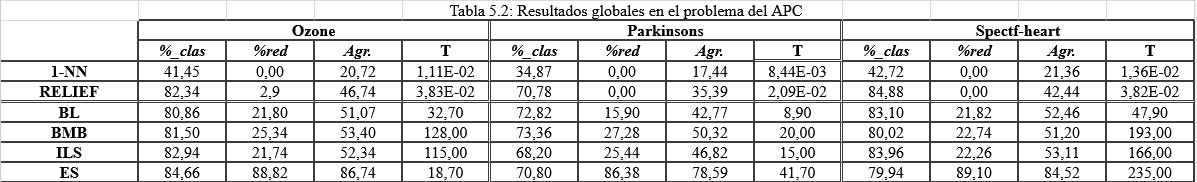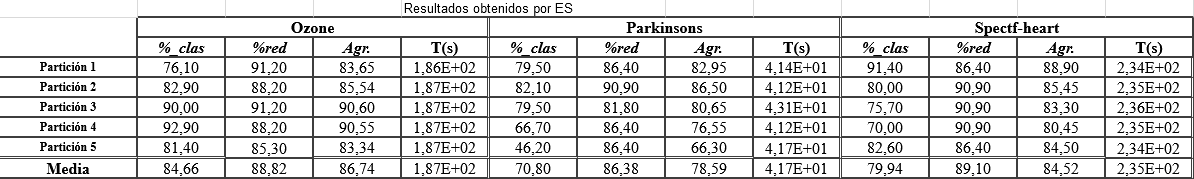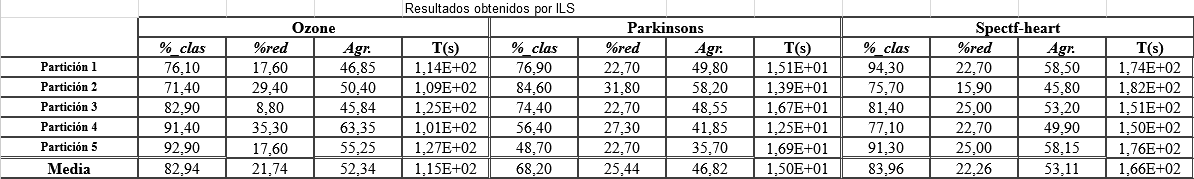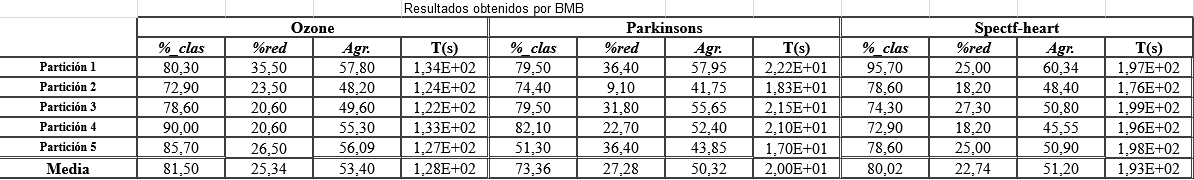

Para empezar podemos ver que para el BMB obtiene resultados ligeramente superiores a BL en todos los datasets excepto por spectf-heart. Esto es esperable. El algoritmo BL no terminaba las 15000 iteraciones ya que se detenía siempre por la otra condición de parada (n vecinos sin mejora) por lo que al realizar 15 arranques de 1000 ejecuciones, es bastante probable que una de estas ejecuciones alcance un óptimo a la misma altura que el BL normal, antes de las 1000 iteraciones. Donde sí que notamos la diferencia es en el tiempo de ejecución. Como BL paraba muy rápido tardabamos muy poco, pero aquí repetimos el proceso otras 15 veces, por lo que es esperable que tarde más.<br>

Con ILS apreciamos unos resultados bastante similares a BMB. Supera a este último en 2 datasets unicamente. Esto también es esperable, realmente ILS sigue un esquema bastante similar a BMB pero aplicando una mutación y quedándose con la mejor solución. En ambos se realizan búsquedas locales, por lo que el hecho de hacer una mutación a ver si mejora solo puede en el peor de los casos no mejorarlo, y en el mejor de ellos mejorarlo valga la redundancia. Lo dicho, es esperable que obtenga resultados ligeramente superiores a BMB y BL por tanto, pero por el componente estocástico se pueden dar casos en los que no sea así.<br>

Con el algoritmo de Enfriamiento Simulado es donde podemos ver los mejores resultados. De todos los algoritmos de la tabla es el que mejor agregado consigue con mucha diferencia gracias a sus altas reducciones, llegando incluso casi al 90% en un dataset. Aunque hay que apreciar también que quizás está consiguiendo una reducción demasiado grande ya que en dos datasets conseguimos porcentajes de clasificación menores que BMB, ILS o incluso BL en algunos casos (la única excepción es el primer dataset, donde obtiene la mejor clasificación). Técnicamente el trabajo del algoritmo es maximizar la función de agregado, y si nos ceñimos a eso es el que mejor resultados obtiene con diferencia. Pero si nos importa obtener un porcentaje de clasificación mayor, quizás podríamos llegar a la conclusión de que ES realiza por lo general unas reducciones algo bruscas y que al tener tan pocos atributos, quizás está perjudicando a el porcentaje de clasificación.<br>

En conclusión, el enfriamiento simulado obtiene muy buenos resultados sacrificando un poco de clasificación. Los otros dos algoritmos se comportan acordes a las características que presentan.